#### Loading libraries

In [19]:
import pandas as pd
import numpy as np

# For clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For cluster evaluation
from sklearn.metrics import davies_bouldin_score, silhouette_score

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Loaded & Merged Datasets

In [20]:
# Reading the raw data
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merged transactions with products
trans_products_df = pd.merge(
    transactions_df,
    products_df,
    on='ProductID',
    how='left',
    suffixes=('_trans', '_prod')
)

# Merged with customers
full_df = pd.merge(
    trans_products_df,
    customers_df,
    on='CustomerID',
    how='left'
)

print(full_df.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_trans                      ProductName     Category  \
0      300.68       300.68  ComfortLiving Bluetooth Speaker  Electronics   
1      300.68       300.68  ComfortLiving Bluetooth Speaker  Electronics   
2      300.68       300.68  ComfortLiving Bluetooth Speaker  Electronics   
3      601.36       300.68  ComfortLiving Bluetooth Speaker  Electronics   
4      902.04       300.68  ComfortLiving Bluetooth Speaker  Electronics   

   Price_prod     CustomerName         Region  SignupDate  
0      300.68   Andrea Jenkins         Europe  2022-12-0

## Feature Engineering

Generated aggregated features that summarize each customer’s behavior :



*   Spending by Category
*   Total Spend
*   Purchase Count
*   Days Since Signup
*   Region or other profile attributes

##### Converted SignupDate to datetime

In [21]:
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
full_df['TransactionDate'] = pd.to_datetime(full_df['TransactionDate'])

##### Aggregate total spending by category

In [22]:
category_spend = full_df.groupby(['CustomerID', 'Category'])['TotalValue'].sum().reset_index()

##### Pivot to wide format

In [23]:
category_spend_pivot = category_spend.pivot(index='CustomerID', columns='Category', values='TotalValue').fillna(0)

##### Added total spend and purchase count

In [24]:
purchase_count = full_df.groupby('CustomerID')['TransactionID'].nunique()
total_spend = full_df.groupby('CustomerID')['TotalValue'].sum()

category_spend_pivot['PurchaseCount'] = purchase_count
category_spend_pivot['TotalSpend'] = total_spend

##### Calculated Days since signup

In [25]:
today = pd.to_datetime('today')
temp_cust = customers_df.copy()
temp_cust['DaysSinceSignup'] = (today - temp_cust['SignupDate']).dt.days

##### Merged the DaysSinceSignup feature

In [26]:
category_spend_pivot = category_spend_pivot.merge(
    temp_cust[['CustomerID', 'DaysSinceSignup', 'Region']],
    how='left',
    on='CustomerID'
)

##### Encoded Region as numeric , I will include it in clustering

In [27]:
region_dummies = pd.get_dummies(category_spend_pivot['Region'], prefix='Region')
category_spend_pivot = pd.concat([category_spend_pivot.drop('Region', axis=1), region_dummies], axis=1)

##### Final feature DataFrame

In [28]:
feature_df = category_spend_pivot.copy()
feature_df.fillna(0, inplace=True)

print(feature_df.head())

  CustomerID    Books  Clothing  Electronics  Home Decor  PurchaseCount  \
0      C0001   114.60      0.00      2827.30      412.62              5   
1      C0002     0.00   1025.46         0.00      837.28              4   
2      C0003     0.00    122.36      1385.20     1217.82              4   
3      C0004  1888.48      0.00      1355.74     2110.66              8   
4      C0005     0.00      0.00      1180.38      853.86              3   

   TotalSpend  DaysSinceSignup  Region_Asia  Region_Europe  \
0     3354.52              930        False          False   
1     1862.74             1077         True          False   
2     2725.38              324        False          False   
3     5354.88              839        False          False   
4     2034.24              894         True          False   

   Region_North America  Region_South America  
0                 False                  True  
1                 False                 False  
2                 False         

## Clustering

### Standardized ( scaled ) the Features

In [29]:
from sklearn.preprocessing import StandardScaler

# Ensured that CustomerID is index
feature_df.set_index('CustomerID', inplace=True)
# Converted to numpy array
X = feature_df.values

scaler = StandardScaler()
# shape: (num_customers, num_features)
X_scaled = scaler.fit_transform(X)

### Choosing the Number of Clusters (k)

##### Since the assignment allows 2 to 10 clusters, my approach is to loop over k from 2 to 10, fit K-Means, and then compute:

* Davies-Bouldin (DB) Index: Lower is better
* Silhouette Score: Higher is better

In [30]:
db_scores = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    db_index = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_index)

    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

##### Visualizing DB Index vs k

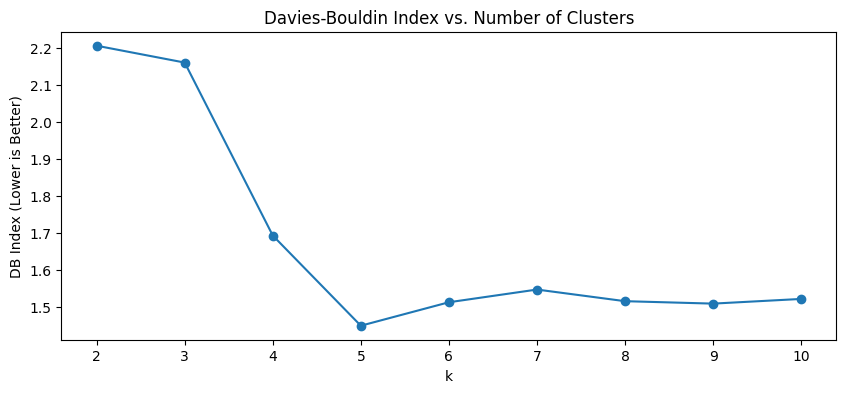

In [31]:
plt.figure(figsize=(10,4))
plt.plot(list(K_range), db_scores, marker='o')
plt.title("Davies-Bouldin Index vs. Number of Clusters")
plt.xlabel("k")
plt.ylabel("DB Index (Lower is Better)")
plt.show()

##### Silhouette Score vs k

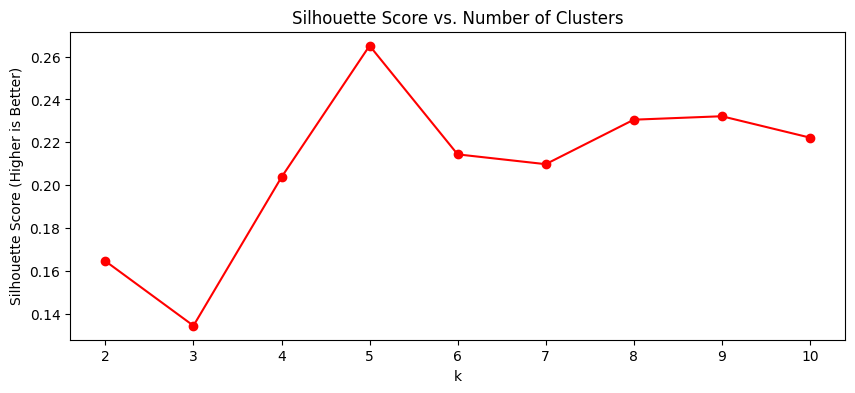

In [32]:
plt.figure(figsize=(10,4))
plt.plot(list(K_range), sil_scores, marker='o', color='red')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("k")
plt.ylabel("Silhouette Score (Higher is Better)")
plt.show()

### My observation :
* At k = 5
* * Davies-Bouldin Index is lowest
* * Silhouette Score is highest
* Thus I am choosing k = 5

In [48]:
k_opt = 5

In [49]:
final_kmeans = KMeans(n_clusters=k_opt, random_state=42)
final_labels = final_kmeans.fit_predict(X_scaled)

##### Assigning cluster labels back to feature_df

In [50]:
feature_df['Cluster'] = final_labels
feature_df.head()

,Books,Clothing,Electronics,Home Decor,PurchaseCount,TotalSpend,DaysSinceSignup,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster
CustomerID,,,,,,,,,,,,
C0001,114.60,0.00,2827.30,412.62,5,3354.52,930,False,False,False,True,1
C0002,0.00,1025.46,0.00,837.28,4,1862.74,1077,True,False,False,False,3
C0003,0.00,122.36,1385.20,1217.82,4,2725.38,324,False,False,False,True,1
C0004,1888.48,0.00,1355.74,2110.66,8,5354.88,839,False,False,False,True,1
C0005,0.00,0.00,1180.38,853.86,3,2034.24,894,True,False,False,False,3


### Evaluating Clusters & DB Index

In [51]:
db_index_final = davies_bouldin_score(X_scaled, final_labels)
silhouette_final = silhouette_score(X_scaled, final_labels)

In [52]:
print(f"Chosen number of clusters (k): {k_opt}")
print(f"Davies-Bouldin Index : {db_index_final:.4f}")
print(f"Silhouette Score : {silhouette_final:.4f}")

Chosen number of clusters (k): 5
Davies-Bouldin Index: 1.4486
Silhouette Score: 0.2651


## Visualizing the Clusters

##### My approach is to use PCA (Principal Component Analysis) to project the data. Then, color points by their cluster label.

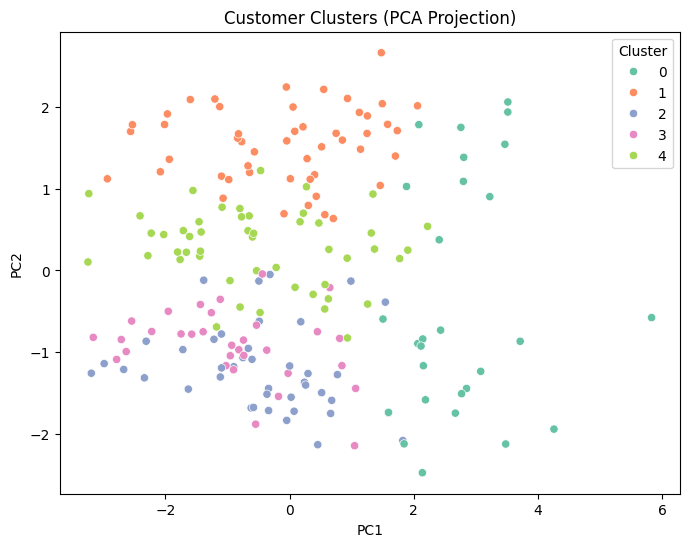

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=final_labels,
    palette='Set2'
)
plt.title("Customer Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.show()